# Estimating Data Values from Plots in the Literature (Part 2)

::: {admonition} Learning Objectives  
After completing this lesson, you should be able to:  
**Part 1 (last lesson):**  
1. open an image file into an interactive widget e.g. screen capture of a data plot from the literature,  
2. find the pixel coordinates of the data points in the plot,  
3. transform the pixel coordinates into plot coordinates correcting for any skew or rotation caused by copying the original paper on a copy machine, and  
4. replot the data and compare to original.  

**Part 2 (this lesson):**   
1. write a function to select points from an image file, 
2. find a general solution for our calibration function so we can eliminate the need to setup and solve 6 equations each time we use the convert function, 
3. write a function to convert pixel points to plot units, and 
4. perform curve fitting using `scipy.optimize import curve_fit` 
:::

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from sympy import solve, Eq, symbols, Matrix
import os

## General solution for transformation matrix and offset

Recall the general formula for transforming points from one coordinate system to another from the previous lesson:  $m \cdot \ (pixel\ coord - \text{pixel offset}) = plot\ values$ where $m$ is the transformation matrix. In matrix notation, we have:  

$$\begin{bmatrix}m11 & m12 \\m21 & m22 \end{bmatrix}\cdot \left( \left[\begin{array}{c}pixX\\ pixY\end{array}\right] - \left[\begin{array}{c}Ox\\ Oy\end{array}\right]\right)=\left[\begin{array}{c}Xvalue\\ Yvalue\end{array}\right]$$

Here we are going to solve for our unknowns, *m11, m12, m21, m22, Ox,* and *Oy* for a general image point *[pixX, pixY]* and its corresponding plot value *[X, Y]*. Recall that we need three sets of points in order to solve.  We will label these *[pixX1, pixY1], [pixX2, pixY2], [pixX3, pixY3]* and corresponding values *[X1,Y1}, [X2,Y2}, [X3,Y3}*.  

In [2]:
# define the symbols in our equations
m11, m12, m21, m22, Ox, Oy, pixX1,pixY1,pixX2,pixY2,pixX3,pixY3,X1,Y1,X2,Y2,X3,Y3 = symbols('m11, m12, m21, m22, Ox, Oy,pixX1,pixY1,pixX2,pixY2,pixX3,pixY3,X1,Y1,X2,Y2,X3,Y3')
# define transformation matrix and offset matrix
m = Matrix([[m11, m12],[m21, m22]])
offset=Matrix([Ox,Oy])

In [3]:
print('Our general equations: \n')
print('eq1 = ')
display(eq1:=Eq(m*(Matrix([pixX1,pixY1])-offset),Matrix([X1,Y1])))
print('eq2 = ')
display(eq2:=Eq(m*(Matrix([pixX2,pixY2])-offset),Matrix([X2,Y2])))
print('eq3 = ')
display(eq3:=Eq(m*(Matrix([pixX3,pixY3])-offset),Matrix([X3,Y3])))

Our general equations: 

eq1 = 


Eq(Matrix([
[m11*(-Ox + pixX1) + m12*(-Oy + pixY1)],
[m21*(-Ox + pixX1) + m22*(-Oy + pixY1)]]), Matrix([
[X1],
[Y1]]))

eq2 = 


Eq(Matrix([
[m11*(-Ox + pixX2) + m12*(-Oy + pixY2)],
[m21*(-Ox + pixX2) + m22*(-Oy + pixY2)]]), Matrix([
[X2],
[Y2]]))

eq3 = 


Eq(Matrix([
[m11*(-Ox + pixX3) + m12*(-Oy + pixY3)],
[m21*(-Ox + pixX3) + m22*(-Oy + pixY3)]]), Matrix([
[X3],
[Y3]]))

In [5]:
print('\n The general solution: ')
sol=solve([eq1,eq2,eq3], [m11,m12,m21,m22,Ox,Oy])
[m_11,m_12,m_21,m_22,O_x,O_y]=np.array(sol[0])
 
display(Eq(Matrix([m11,m12,m21,m22,Ox,Oy]),Matrix([m_11,m_12,m_21,m_22,O_x,O_y])))


 The general solution: 


Eq(Matrix([
[m11],
[m12],
[m21],
[m22],
[ Ox],
[ Oy]]), Matrix([
[ (X1*pixY2 - X1*pixY3 - X2*pixY1 + X2*pixY3 + X3*pixY1 - X3*pixY2)/(pixX1*pixY2 - pixX1*pixY3 - pixX2*pixY1 + pixX2*pixY3 + pixX3*pixY1 - pixX3*pixY2)],
[-(X1*pixX2 - X1*pixX3 - X2*pixX1 + X2*pixX3 + X3*pixX1 - X3*pixX2)/(pixX1*pixY2 - pixX1*pixY3 - pixX2*pixY1 + pixX2*pixY3 + pixX3*pixY1 - pixX3*pixY2)],
[ (Y1*pixY2 - Y1*pixY3 - Y2*pixY1 + Y2*pixY3 + Y3*pixY1 - Y3*pixY2)/(pixX1*pixY2 - pixX1*pixY3 - pixX2*pixY1 + pixX2*pixY3 + pixX3*pixY1 - pixX3*pixY2)],
[-(Y1*pixX2 - Y1*pixX3 - Y2*pixX1 + Y2*pixX3 + Y3*pixX1 - Y3*pixX2)/(pixX1*pixY2 - pixX1*pixY3 - pixX2*pixY1 + pixX2*pixY3 + pixX3*pixY1 - pixX3*pixY2)],
[                   (X1*Y2*pixX3 - X1*Y3*pixX2 - X2*Y1*pixX3 + X2*Y3*pixX1 + X3*Y1*pixX2 - X3*Y2*pixX1)/(X1*Y2 - X1*Y3 - X2*Y1 + X2*Y3 + X3*Y1 - X3*Y2)],
[                   (X1*Y2*pixY3 - X1*Y3*pixY2 - X2*Y1*pixY3 + X2*Y3*pixY1 + X3*Y1*pixY2 - X3*Y2*pixY1)/(X1*Y2 - X1*Y3 - X2*Y1 + X2*Y3 + X3*Y1 - X3*Y2)]]))

## Write new functions `selectdata()` and `cal()`

Now we take our code for converting pixel points to plot coordinates from the previous lesson and eliminate the solve step by directly defining our calibration variables with those above.  

In [16]:
import numpy as np    

def cal(pixpts, plotpts, datatoconvert):    
    ''' 
        Needs "import numpy as np"
        pixpts = list of three pixel points (typically along axes)
        plotpts = list of three points corresponding to pixpts but in plot units
        datatoconvert = list of pixel points to convert to plot coordinates
    '''
    
    xpx1, ypx1 = pixpts[0]
    x1, y1 = plotpts[0]
    xpx2, ypx2 = pixpts[1]
    x2, y2 = plotpts[1]
    xpx3, ypx3 = pixpts[2]
    x3, y3 = plotpts[2]
    
    # general solution for calibration constants
    m11=(x1*ypx2 - x1*ypx3 - x2*ypx1 + x2*ypx3 + x3*ypx1 - x3*ypx2)/(xpx1*ypx2 - xpx1*ypx3 - xpx2*ypx1 + xpx2*ypx3 + xpx3*ypx1 - xpx3*ypx2)
    m12=-(x1*xpx2 - x1*xpx3 - x2*xpx1 + x2*xpx3 + x3*xpx1 - x3*xpx2)/(xpx1*ypx2 - xpx1*ypx3 - xpx2*ypx1 + xpx2*ypx3 + xpx3*ypx1 - xpx3*ypx2)
    m21=(y1*ypx2 - y1*ypx3 - y2*ypx1 + y2*ypx3 + y3*ypx1 - y3*ypx2)/(xpx1*ypx2 - xpx1*ypx3 - xpx2*ypx1 + xpx2*ypx3 + xpx3*ypx1 - xpx3*ypx2)
    m22=-(-xpx1*y2 + xpx1*y3 + xpx2*y1 - xpx2*y3 - xpx3*y1 + xpx3*y2)/(xpx1*ypx2 - xpx1*ypx3 - xpx2*ypx1 + xpx2*ypx3 + xpx3*ypx1 - xpx3*ypx2)
    Ox=(-x1*xpx2*y3 + x1*xpx3*y2 + x2*xpx1*y3 - x2*xpx3*y1 - x3*xpx1*y2 + x3*xpx2*y1)/(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2)
    Oy=(x1*y2*ypx3 - x1*y3*ypx2 - x2*y1*ypx3 + x2*y3*ypx1 + x3*y1*ypx2 - x3*y2*ypx1)/(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2)
    
    # define our calibrated transf matrix, m_cal, and our calibrated offset, offset_cal
    m_cal=[[m11, m12],[m21,m22]]
    offset_cal=[Ox, Oy]
    
    # return as numpy arrays
    # return(np.array(m_cal), np.array(offset_cal))
    plot_data=np.array([np.matmul(m_cal, point-offset_cal) for point in np.array(datatoconvert)])

    return(plot_data)

:::{tip}  
You can use the `help()` function to get more information about other functions.  If you want to include help in your own functions, include your message between triple quotes as shown above in the function `cal()`.  Then type `help(cal)` and you should see the following output:   

```yaml
Help on function cal in module __main__:  
  
cal(pixpts, plotpts, datatoconvert)  
    Needs "import numpy as np"  
    pixpts = list of three pixel points (typically along axes)  
    plotpts = list of three points corresponding to pixpts but in plot units  
    datatoconvert = list of pixel points to convert to plot coordinates 
```

:::


Now lets put our code for selecting pixel points from last lesson into a function called `selectdata`. 

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import os

def selectdata(path_to_image_file, filename):
    ''' 
        path_to_image_file example: r"C:/Users/Sean/images" 
        filename example: "xrd data.png"  
        pixel data stored in global variable "pixel_positions"
    '''
    plt.close('all')
    %matplotlib widget

    image_file=os.path.join(path_to_image_file, filename)
    
    #now we have 1 row and 2 columns i.e. 2 figures in a row
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))

    # gridspec_kw={'width_ratios': [2, 2]} can be used above if needed

    # turn off the x, y axis on the image - the axis doesn't make sense for an image
    ax1.axis(False)
    
    img = mpimg.imread(image_file) #matplotlib
    # .add_axes([left, bottom, width, height])
    image_axis = fig.add_axes([0.015, 0, 0.40, 0.9], zorder=10, anchor=(0.5,0.5)) #zorder places figure on top of anything else in axes
    image_axis.imshow(img)
    image_axis.axis('off')

    # recall from part 1 that image files have coord in left top corner so we need to correct by the y-dimension of the file
    ydim=img.shape[0]

    # setting title and labels for ax1 (figure on the left)
    ax1.set_title('Click on data you want to collect below')
    ax1.set_xlabel('x-pixel position')
    ax1.set_ylabel('y-pixel position')

    global pixel_positions #makes pixel_positions a global variable so we have access to it outside this function
    pixel_positions = []
    def onclick(event):
        if event.button==1:
            pixel_positions.append([event.xdata,ydim-event.ydata])
            ax2.set_title(f'Last click: [{event.xdata:.3f}, {ydim-event.ydata:.3f}]')
            ax2.scatter(event.xdata, ydim-event.ydata, marker='o', c='r', edgecolor='k') #adding scatter plot
    
    cid=fig.canvas.mpl_connect('button_press_event', onclick) 
    plt.show()

## Test the functions `selectdata()` and `cal()`

Let's take a look at the x-ray pattern for BCC Tungsten.  The indices of the peaks (from left to right) are (110), (200), (211), (220), and (310). We will select the top of each peak so we can determine the angle 2$\theta$.  First we select our calibration points: 

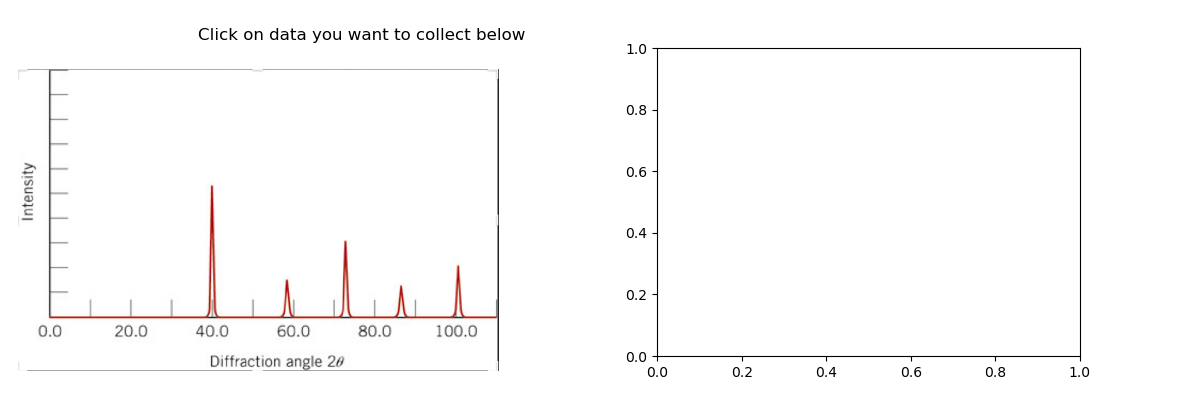

In [44]:
selectdata(r'../images','diffraction.png')

In [45]:
calpixels=pixel_positions
display(calpixels)
calplot=[[100,0],[0,0],[0,1]]

[[1180.3437500000002, 147.73730942408247],
 [80.93750000000001, 147.73730942408247],
 [80.93750000000001, 755.803976090749]]

Next we select the top of each peak. 

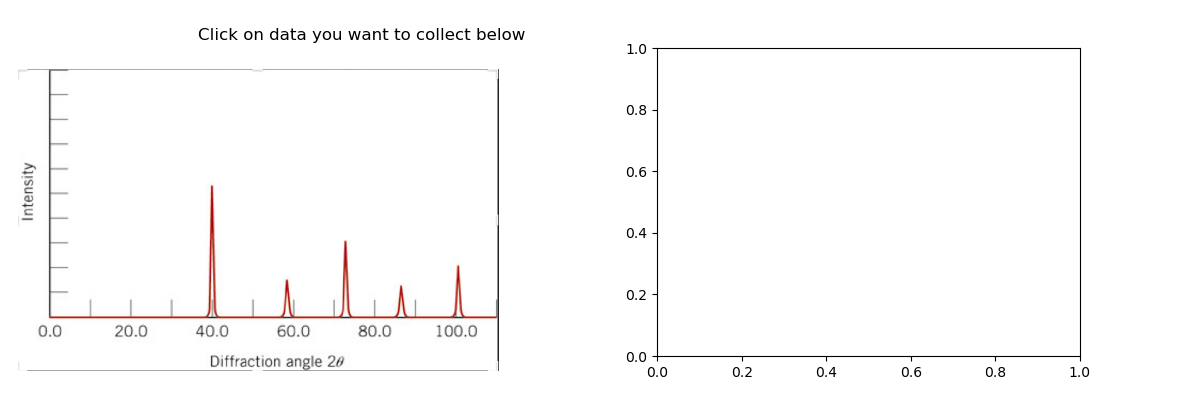

In [46]:
selectdata(r'../images','diffraction.png')

In [47]:
peakpix=pixel_positions
display(peakpix)

[[523.4145833333334, 505.5194010416666],
 [724.2937500000002, 247.63398437499995],
 [884.4541666666668, 353.50273437499993],
 [1036.4708333333335, 234.0610677083332],
 [1188.4875000000002, 288.35273437499995]]

Now let's convert the peakpix to plot units by using `cal()`. 

In [48]:
data=cal(calpixels, calplot, peakpix)
data

array([[ 40.24691358,   0.58839287],
       [ 58.51851852,   0.16428573],
       [ 73.08641975,   0.33839287],
       [ 86.91358025,   0.1419643 ],
       [100.74074074,   0.23125001]])

We get the following. 

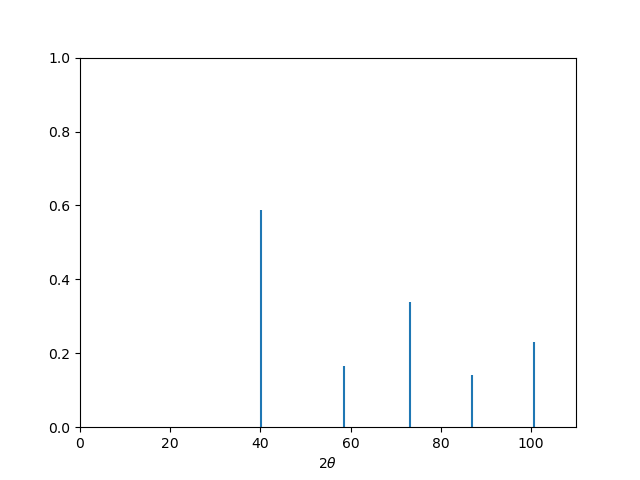

In [76]:
plt.close('all')
plt.stem(data[:,0], data[:,1], markerfmt=' ', basefmt=' ')
plt.xlim(0,110)
plt.ylim(0,1)
plt.xlabel(r"$2 \theta$")
plt.show()

The peak positions are stored in `data[:,0]`.  These positions are $2\theta$. Let's calculate the d-spacing correspoonding to each peak and the lattice parameter, $a$, based on the d-spacing.  Ideally, $a$ would be identical in each case but due to some inaccuracies in selecting the peak position we will see some variation in $a$.  Let's find out how much.  

\begin{gather*}
2\ d_{hkl}\ \sin(\theta)=n\ \lambda \\
a=d_{hkl}\ \sqrt{h^2+k^2+l^2}
\end{gather*}

In [155]:
theta=data[:,0]/2
dhkl=0.1542/2/np.sin(np.deg2rad(theta))
planes=[[1,1,0], [2,0,0], [2,1,1], [2,2,0],[3,1,0]]

alist=np.array([dhkl*np.sqrt(hkl[0]**2+hkl[1]**2+hkl[2]**2) for [dhkl, hkl] in zip(dhkl,planes)])
print(f'd-spacings for (110), (200), (211), (220), and (310) = {np.round(dhkl,4)} nm \n')
print(f'lattice parameter for (110), (200), (211), (220), and (310) = {np.round(alist,4)} nm \n')
print(f'The average lattice parameter is {alist.mean():.4f} with a standard deviation of {alist.std():.6f}')
print('The literature value for tungsten is 0.31652 nm')

d-spacings for (110), (200), (211), (220), and (310) = [0.2241 0.1577 0.1295 0.1121 0.1001] nm 

lattice parameter for (110), (200), (211), (220), and (310) = [0.3169 0.3155 0.3172 0.3171 0.3166] nm 

The average lattice parameter is 0.3166 with a standard deviation of 0.000611
The literature value for tungsten is 0.31652 nm


## Exercises

### Problem 1

Combine the data from the three plots below onto a single plot.  Use different colors and symbols for each dataset.  Label your axes including units.  Don't connect the points. Include a legend on your plot where (a) 60 min; (b) 120 min; and (c) 480 min nitrocarburizing.  Set your y-scale to 400 min - 1200 max and your x-scale as 0 min 90 max.  

::: {note}  
Click on the image below to download.  
:::

:::{image} ../images/08_hardness_data.png
:height: 1600px
:name: navigator
:align: center
:::

<img alt="../images/filename.png" src="../images/08_hardness_data.png" width=800px>

### Problem 2

Determine the thickness of the dark and light regions in the multilayer film shown in the image below.  Use at least 10 points to determine the thickness for each region. Provide the average and standard deviation of your two datasets. Provide your answers in nanometers. Make sure your notebook is well documented so it is clear what your code is doing.    

:::{image} ../images/08_multilayer.png
:height: 500px
:name: navigator
:align: center
:::

<p style="line-height:100%"><font size=2>Image from:</font>
<font size=2>Sergiy Yulin, Torsten Feigl, Viatcheslav Nesterenko, Mark Schürmann, Marco Perske, Hagen Pauer, Tobias Fiedler and Norbert Kaiser. *EUV multilayer coatings: potentials and limits.* presentation at the 2012 International Workshop on EUV Lithography, Thursday, 7 June 2012. https://www.euvlitho.com/2012/P26.pdf accessed 15 Sept 2022 </font></p>

<img alt="../images/filename.png" src="../images/08_multilayer.png" width=200px>